# Exploratory Data Analysis

## Download Data

In [ ]:
import pandas as pd #type: ignore
from ucimlrepo import fetch_ucirepo #type: ignore
from scipy.io import arff #type: ignore
import os
from enum import Enum
from sklearn.ensemble import RandomForestClassifier #type: ignore
from sklearn.model_selection import train_test_split #type: ignore
from sklearn.model_selection import GridSearchCV #type: ignore
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #type: ignore

In [ ]:
def fetch_data():
    phishing_websites = fetch_ucirepo(id=327) 
    
    X = phishing_websites.data.features 
    y = phishing_websites.data.targets 

    return pd.concat([X, y], axis=1)

In [ ]:
DATASET_PATH= "./data/phishing_websites.arff"

def fetch_data_local():
    arff_file_path = os.path.join(os.path.dirname(__file__), DATASET_PATH)
    data, _ = arff.loadarff(arff_file_path)
    
    df = pd.DataFrame(data)
    X = df.drop('Result', axis=1)
    y = df['Result']

    return pd.concat([X, y], axis=1)

In [ ]:
class Encoding(Enum):
    BINARY = 0
    TERNARY = 1

attributes_encoding = [
    {"attribute": "having_ip_address", "encoding": Encoding.BINARY},                            # { -1, 1 }
    {"attribute": "url_length", "encoding": Encoding.TERNARY},                                  # { 1, 0, -1 }
    {"attribute": "shortining_service", "encoding": Encoding.BINARY},                           # { 1, -1 }
    {"attribute": "having_at_symbol", "encoding": Encoding.BINARY},                             # { 1, -1 }
    {"attribute": "double_slash_redirecting", "encoding": Encoding.BINARY},                     # { -1, 1 }
    {"attribute": "prefix_suffix", "encoding": Encoding.BINARY},                                # { -1, 1 }
    {"attribute": "having_sub_domain", "encoding": Encoding.TERNARY},                           # { -1, 0, 1 }
    {"attribute": "sslfinal_state", "encoding": Encoding.TERNARY},                              # { -1, 1, 0 }
    {"attribute": "domain_registration_length", "encoding": Encoding.BINARY},                   # { -1, 1 }
    {"attribute": "favicon", "encoding": Encoding.BINARY},                                      # { 1, -1 }
    {"attribute": "port", "encoding": Encoding.BINARY},                                         # { 1, -1 }
    {"attribute": "https_token", "encoding": Encoding.BINARY},                                  # { -1, 1 }
    {"attribute": "request_url", "encoding": Encoding.BINARY},                                  # { 1, -1 }
    {"attribute": "url_of_anchor", "encoding": Encoding.TERNARY},                               # { -1, 0, 1 }
    {"attribute": "links_in_tags", "encoding": Encoding.TERNARY},                               # { 1, -1, 0 }
    {"attribute": "sfh", "encoding": Encoding.TERNARY},                                         # { -1, 1, 0 }
    {"attribute": "submitting_to_email", "encoding": Encoding.BINARY},                          # { -1, 1 }
    {"attribute": "abnormal_url", "encoding": Encoding.BINARY},                                 # { -1, 1 }
    {"attribute": "redirect", "encoding": Encoding.BINARY},                                     # { 0, 1 }
    {"attribute": "on_mouseover", "encoding": Encoding.BINARY},                                 # { 1, -1 }
    {"attribute": "rightclick", "encoding": Encoding.BINARY},                                   # { 1, -1 }
    {"attribute": "popupwindow", "encoding": Encoding.BINARY},                                  # { 1, -1 }
    {"attribute": "iframe", "encoding": Encoding.BINARY},                                       # { 1, -1 }
    {"attribute": "age_of_domain", "encoding": Encoding.BINARY},                                # { -1, 1 }
    {"attribute": "dnsrecord", "encoding": Encoding.BINARY},                                    # { -1, 1 }
    {"attribute": "web_traffic", "encoding": Encoding.TERNARY},                                 # { -1, 0, 1 }
    {"attribute": "page_rank", "encoding": Encoding.BINARY},                                    # { -1, 1 }
    {"attribute": "google_index", "encoding": Encoding.BINARY},                                 # { 1, -1 }
    {"attribute": "links_pointing_to_page", "encoding": Encoding.TERNARY},                      # { 1, 0, -1 }
    {"attribute": "statistical_report", "encoding": Encoding.BINARY},                           # { -1, 1 }
    {"attribute": "result", "encoding": Encoding.BINARY},                                       # { -1, 1 }
]

def encode_data(data: pd.DataFrame) -> pd.DataFrame:
    encoding_map = {attr['attribute']: attr['encoding'] for attr in attributes_encoding}

    encoded_data = []
    for col in data.columns:
        if col in encoding_map:
            encoding = encoding_map[col]
            if encoding == Encoding.BINARY:
                encoded_data.append(data[col].map({-1: 0, 1: 1, 0: 0}).rename(col))
            elif encoding == Encoding.TERNARY:
                encoded_data.append(data[col].map({-1: -1, 0: 0, 1: 1}).rename(col))
            else:
                raise ValueError(f"Unsupported encoding type for attribute '{col}': {encoding}")
        else:
            print(f"Warning: No encoding specified for '{col}'. Including as-is.")
            encoded_data.append(data[col])

    return pd.concat(encoded_data, axis=1)


def map_to_boolean(data: pd.DataFrame) -> pd.DataFrame:
    encoded_data = encode_data(data.copy())
    encoding_map = {attr['attribute']: attr['encoding'] for attr in attributes_encoding}
    mapped_data = []
    for col in encoded_data.columns:
        if col in encoding_map:
            encoding = encoding_map[col]
            if encoding == Encoding.BINARY:
                mapped_data.append(encoded_data[col].map({0: False, 1: True}).rename(col))
            elif encoding == Encoding.TERNARY:
                mapped_data.append(encoded_data[col].rename(col))
        else:
            print(f"Warning: No encoding specified for '{col}'. Including as-is.")
            mapped_data.append(encoded_data[col])

    return pd.concat(mapped_data, axis=1)
        

In [50]:
def mapping_function(feature_name, value):
    mappings = {
        "having_ip_address": {
            0: "Phishing (Domain has an IP address)",
            1: "Legitimate (Domain does not have an IP address)"
        },
        "url_length": {
            1: "Legitimate (URL length < 54)",
            0: "Suspicious (54 ≤ URL length ≤ 75)",
            -1: "Phishing (URL length > 75)"
        },
        "shortining_service": {
            1: "Legitimate (Does not use a shortening service)",
            0: "Phishing (Uses a shortening service)"
        },
        "having_at_symbol": {
            1: "Phishing (URL contains '@' symbol)",
            0: "Legitimate (URL does not contain '@' symbol)"
        },
        "double_slash_redirecting": {
            0: "Phishing (Last occurrence of '//' > 7)",
            1: "Legitimate (Last occurrence of '//' ≤ 7)"
        },
        "prefix_suffix": {
            0: "Phishing (URL starts/ends with hyphen/dot)",
            1: "Legitimate (URL does not start/end with hyphen/dot)"
        },
        "having_sub_domain": {
            -1: "Phishing (URL has more than one subdomain)",
            0: "Suspicious (URL has a single subdomain)",
            1: "Legitimate (URL has no subdomain)"
        },
        "sslfinal_state": {
            -1: "Phishing (SSL certificate is not valid or does not exist)",
            0: "Suspicious (SSL certificate is valid but not fully secured)",
            1: "Legitimate (SSL certificate is valid and fully secured)"
        },
        "domain_registration_length": {
            0: "Phishing (Domain registration < 6 months)",
            1: "Legitimate (Domain registration ≥ 6 months)"
        },
        "favicon": {
            1: "Legitimate (Favicon exists and is legitimate)",
            0: "Phishing (Favicon is missing or suspicious)"
        },
        "port": {
            1: "Legitimate (Uses standard ports like 80, 443)",
            0: "Phishing (Uses non-standard ports)"
        },
        "https_token": {
            0: "Phishing (No 'https' or mixed content)",
            1: "Legitimate (Contains 'https' and no mixed content)"
        },
        "request_url": {
            1: "Legitimate (Request URL is legitimate)",
            0: "Phishing (Request URL is not legitimate)"
        },
        "url_of_anchor": {
            -1: "Phishing (Anchor text is misleading or no description)",
            0: "Suspicious (Anchor text is generic or neutral)",
            1: "Legitimate (Anchor text is descriptive)"
        },
        "links_in_tags": {
            1: "Legitimate (No links or links point to legitimate sites)",
            -1: "Phishing (Links point to suspicious sites)",
            0: "Suspicious (Links in tags are neutral)"
        },
        "sfh": {
            -1: "Phishing (Form action does not point to a legitimate site)",
            0: "Suspicious (Form action points to a generic form handler)",
            1: "Legitimate (Form action points to a legitimate site)"
        },
        "submitting_to_email": {
            0: "Phishing (Form submits data to an email address)",
            1: "Legitimate (Form does not submit data to an email address)"
        },
        "abnormal_url": {
            0: "Phishing (URL contains unusual characters or patterns)",
            1: "Legitimate (URL does not contain unusual characters or patterns)"
        },
        "redirect": {
            0: "Suspicious (URL performs redirection)",
            1: "Legitimate (URL does not perform redirection)"
        },
        "on_mouseover": {
            1: "Legitimate (Mouseover event is not suspicious)",
            0: "Phishing (Mouseover event triggers suspicious behavior)"
        },
        "rightclick": {
            1: "Legitimate (Right-click is enabled)",
            0: "Phishing (Right-click is disabled)"
        },
        "popupwindow": {
            1: "Legitimate (Pop-up windows require user action)",
            0: "Phishing (Pop-up windows generated without user action)"
        },
        "iframe": {
            1: "Legitimate (Uses iframes from the same domain)",
            0: "Phishing (Uses iframes from different domains)"
        },
        "age_of_domain": {
            0: "Phishing (Domain is less than 6 months old)",
            1: "Legitimate (Domain is ≥ 6 months old)"
        },
        "dnsrecord": {
            0: "Phishing (No DNS record or suspicious DNS record)",
            1: "Legitimate (Valid DNS record)"
        },
        "web_traffic": {
            -1: "Phishing (Low or no web traffic)",
            0: "Suspicious (Moderate web traffic)",
            1: "Legitimate (High web traffic)"
        },
        "page_rank": {
            0: "Phishing (Low or no page rank)",
            1: "Legitimate (High page rank)"
        },
        "google_index": {
            1: "Legitimate (Indexed by Google)",
            0: "Phishing (Not indexed by Google)"
        },
        "links_pointing_to_page": {
            1: "Legitimate (Many legitimate links pointing to the page)",
            0: "Suspicious (Few links pointing to the page)",
            -1: "Phishing (Few or no legitimate links pointing to the page)"
        },
        "statistical_report": {
            0: "Phishing (Indicates malicious behavior)",
            1: "Legitimate (Indicates legitimate behavior)"
        },
        "result": {
            0: "Phishing",
            1: "Legitimate"
        }
    }
    
    if feature_name in mappings:
        if value in mappings[feature_name]:
            return mappings[feature_name][value]
        else:
            return "Unknown value"
    else:
        return "Unknown feature"


## Diverging Bar Chart

In [ ]:
import pandas as pd #type: ignore
import matplotlib.pyplot as plt #type: ignore
import seaborn as sns #type: ignore

In [ ]:
raw_data = fetch_data()
encoded_data = encode_data(raw_data.copy())

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='result', data=encoded_data, palette='coolwarm')
plt.title("Distribution of Target Variable ('result')")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

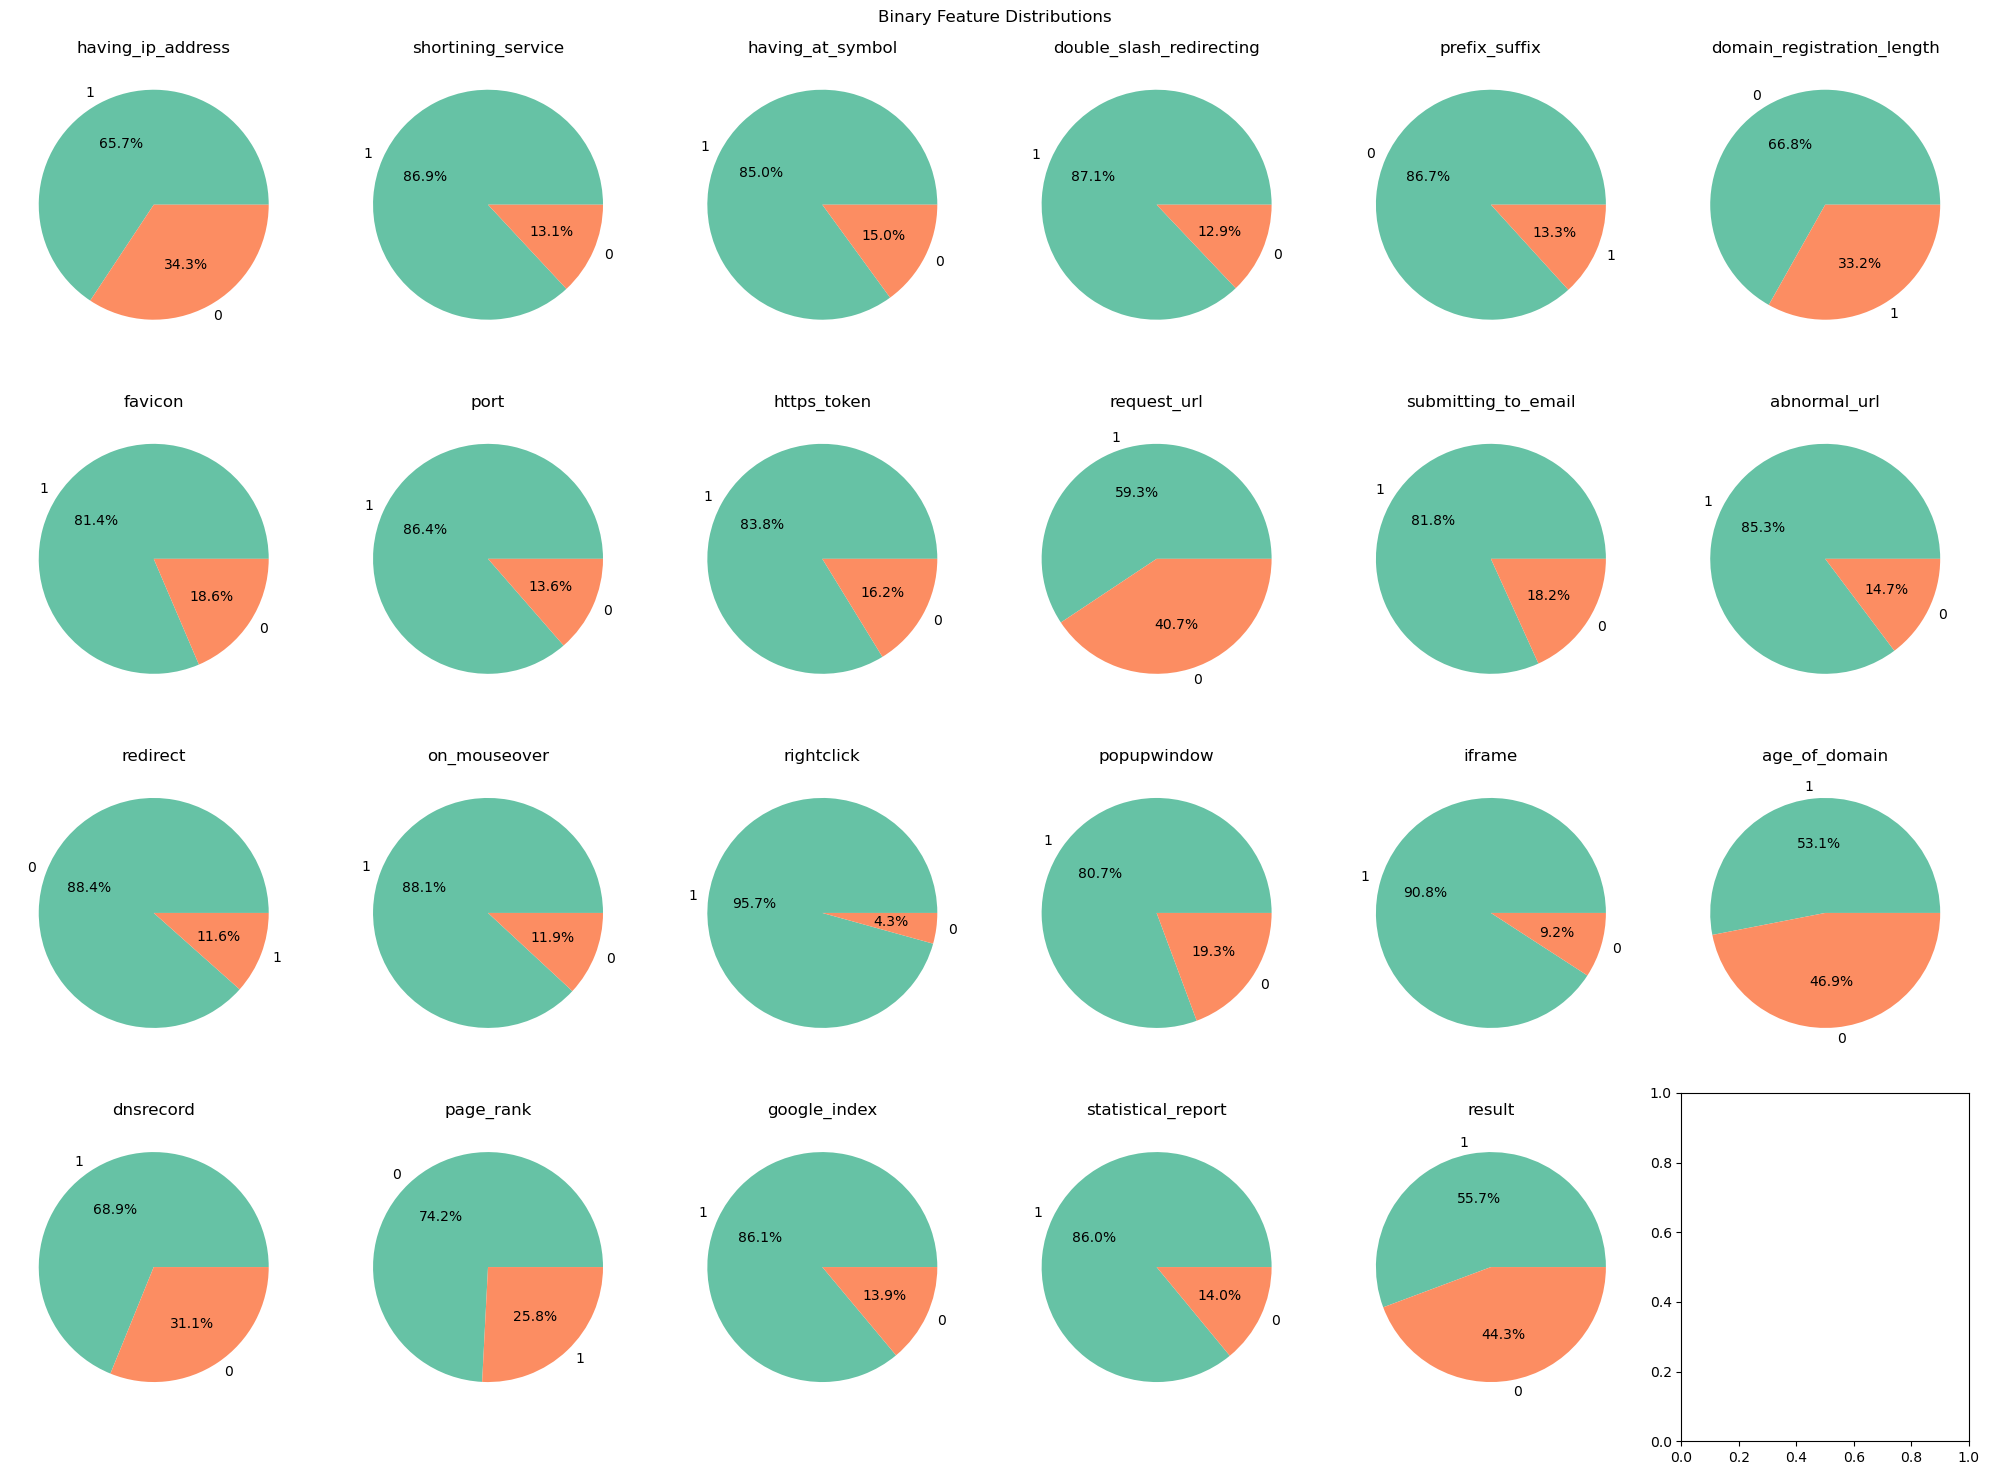

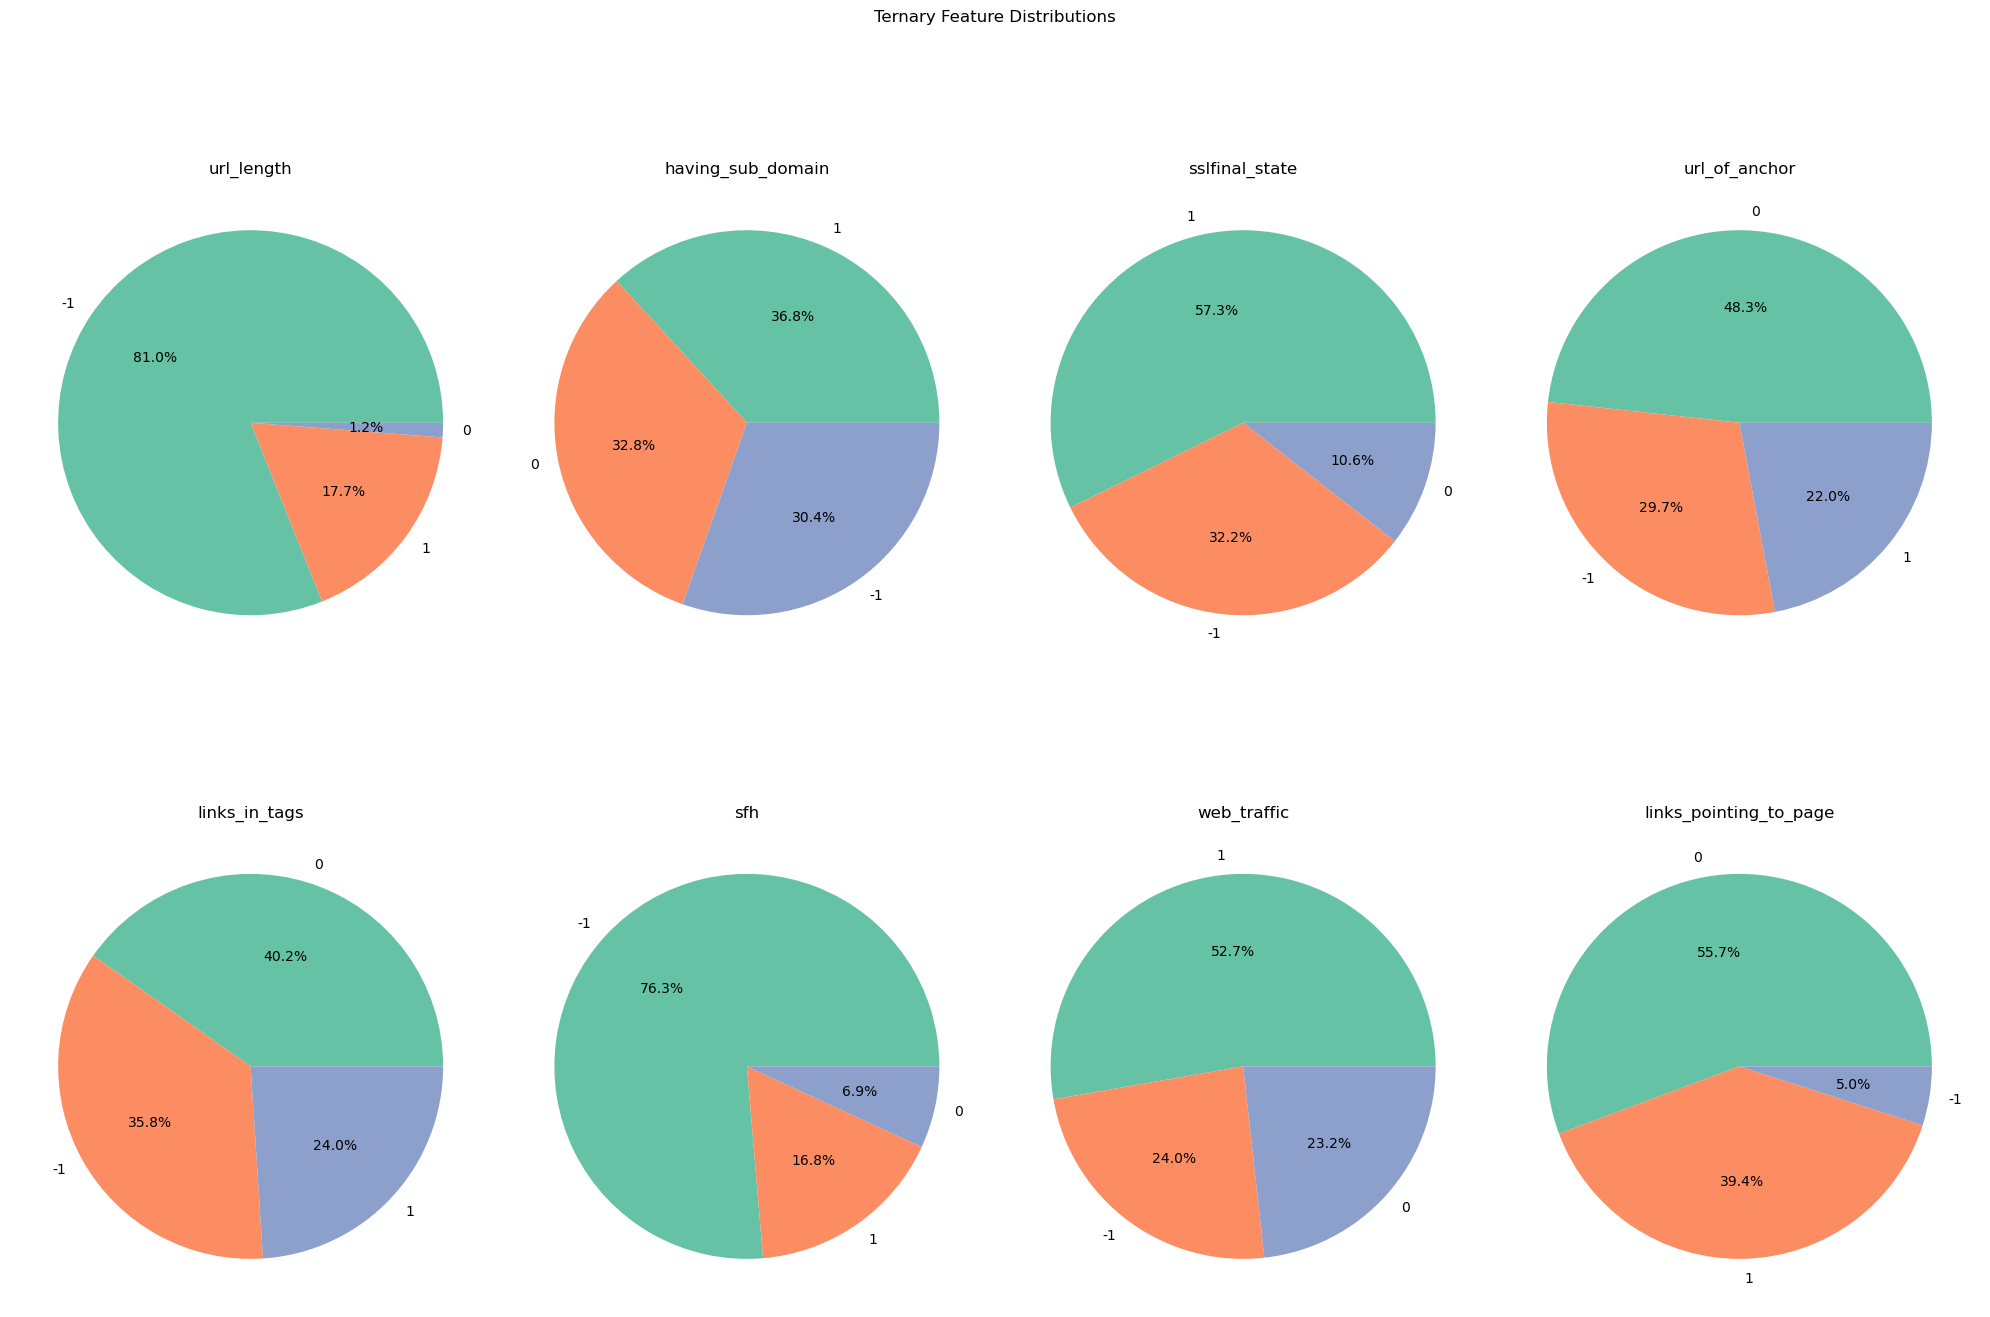

In [36]:
binary_features = [col for col in encoded_data.columns if len(encoded_data[col].unique()) == 2]
ternary_features = [col for col in encoded_data.columns if len(encoded_data[col].unique()) == 3]


fig, axes = plt.subplots(4, 6, figsize=(20, 15))
for ax, feature in zip(axes.flat, binary_features):
    data = encoded_data[feature].value_counts(normalize=True)
    ax.pie(data, labels=data.index, autopct='%1.1f%%', colors=["#66c2a5", "#fc8d62"])
    ax.set_title(feature)
plt.suptitle("Binary Feature Distributions")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 4, figsize=(20, 15))
for ax, feature in zip(axes.flat, ternary_features):
    data = encoded_data[feature].value_counts(normalize=True)
    ax.pie(data, labels=data.index, autopct='%1.1f%%', colors=["#66c2a5", "#fc8d62", "#8da0cb"])
    ax.set_title(feature)
    ax.set_title(feature)
plt.suptitle("Ternary Feature Distributions")
plt.tight_layout()
plt.show()



In [47]:
def draw_pie(data, feature):
    data = data[feature].value_counts(normalize=True)
    labels = [f"{mapping_function(feature, value)}" for value, _ in data.items()]
    plt.pie(data, labels=labels, autopct='%1.1f%%', colors=["#66c2a5", "#fc8d62", "#8da0cb"])
    plt.title(f"Distribution of '{feature}'")
    plt.show()

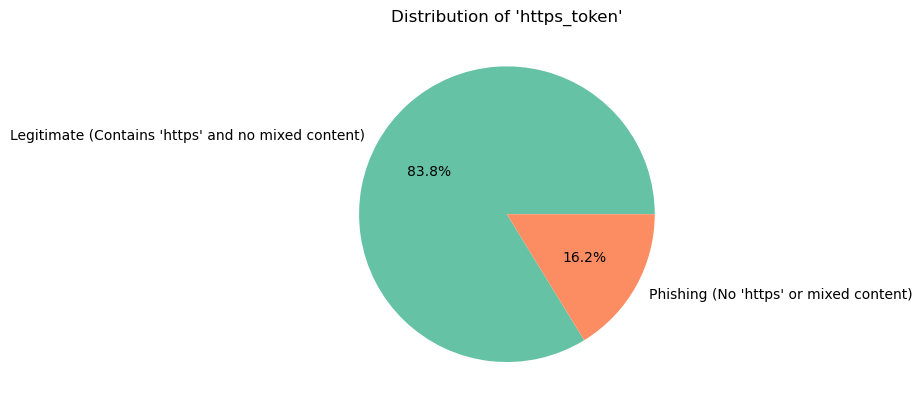

In [54]:
draw_pie(encoded_data.copy(), "https_token")

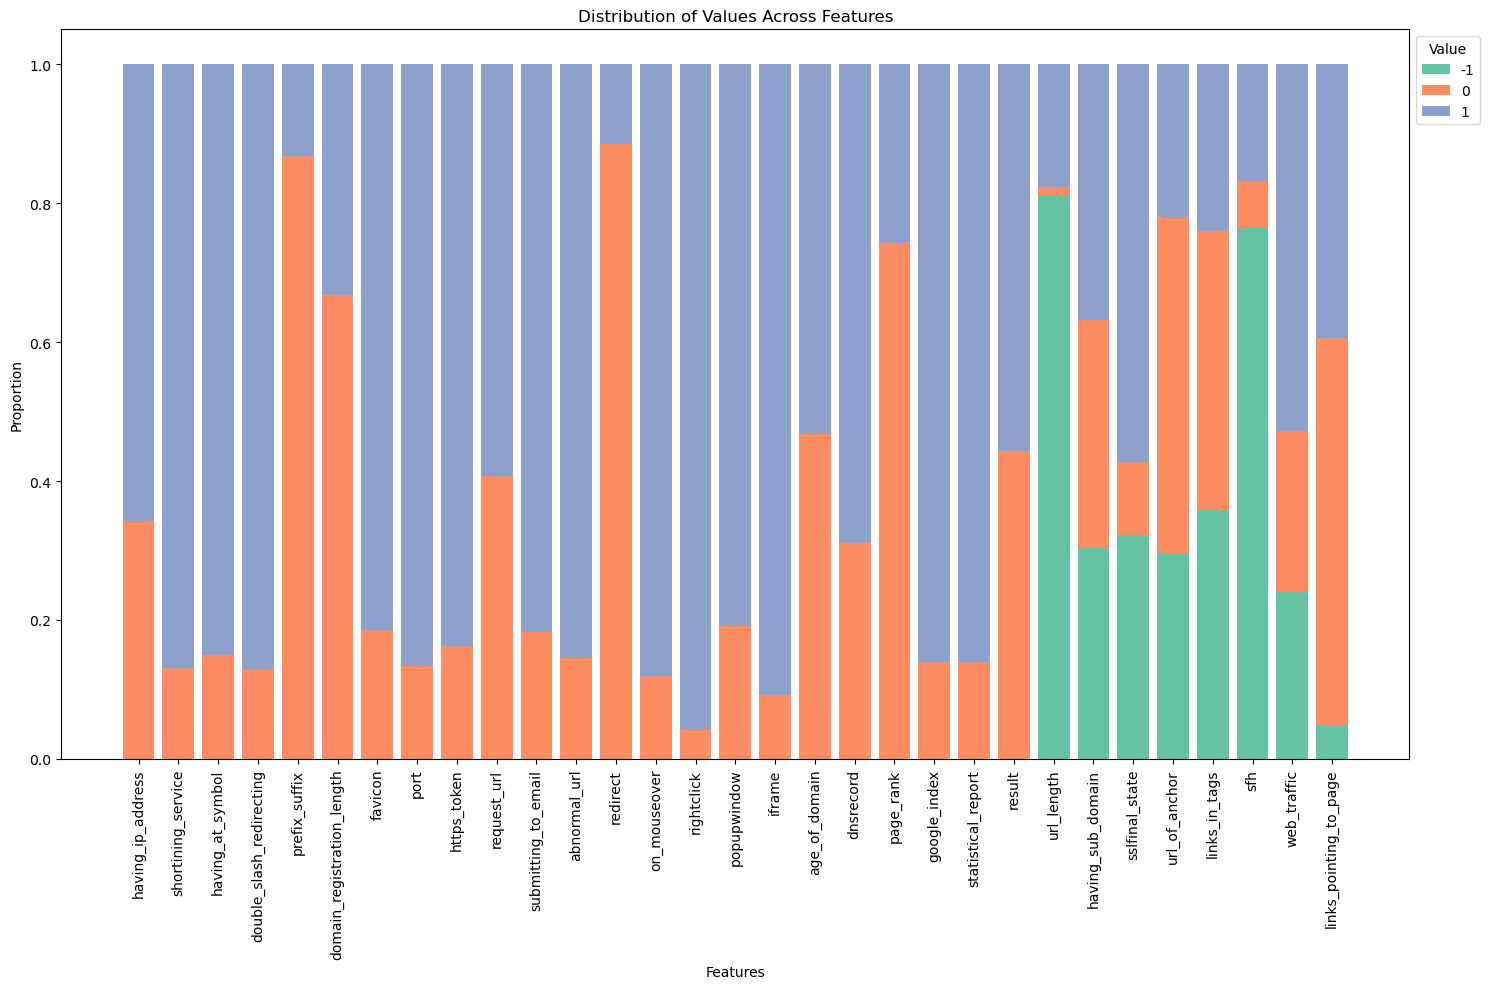

In [55]:
binary_features = [col for col in encoded_data.columns if len(encoded_data[col].unique()) == 2]
ternary_features = [col for col in encoded_data.columns if len(encoded_data[col].unique()) == 3]
all_features = binary_features + ternary_features

feature_value_counts = {feature: encoded_data[feature].value_counts(normalize=True) for feature in all_features}

value_counts_df = pd.DataFrame(feature_value_counts).fillna(0)

fig, ax = plt.subplots(figsize=(15, 10))

colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
value_labels = value_counts_df.index.tolist()

bottom = None
for idx, label in enumerate(value_labels):
    ax.bar(value_counts_df.columns, value_counts_df.loc[label], bottom=bottom, label=str(label), color=colors[idx])
    bottom = value_counts_df.loc[:label].sum() if bottom is None else bottom + value_counts_df.loc[label]

ax.set_xlabel("Features")
ax.set_ylabel("Proportion")
ax.set_title("Distribution of Values Across Features")
ax.legend(title="Value", loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()